# Exploratory Spatio-Temporal Data Analysis
# Part 1 - Data Inspection and Descriptive Statistics - Summary Statistics

In [1]:
import gc

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

import folium
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [2]:
# ds = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_power_nasa_data.nc')

In [3]:
# ds

In [4]:
polars_df = pl.read_parquet("/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_power_nasa_data.parquet")

In [5]:
polars_df.head()

time,lat,lon,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN,PRECTOTCORR_mm
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01 00:00:00,-11.5,35.0,35.578125,25.404688,300.203125,92057.3125,1.9765625,2.5234375,0.015808,72.1875,0.640625,0.6328125,0.65625,94.207031,178.519531,0.951856
2001-01-01 00:00:00,-11.5,35.625,74.953125,25.084375,298.835938,93466.0,1.859375,2.8046875,0.016235,77.8125,0.671875,0.6640625,0.6875,96.116211,186.345703,1.583561
2001-01-01 00:00:00,-11.5,36.25,65.9375,24.951563,298.679688,94211.625,2.4140625,3.515625,0.016052,78.3125,0.6796875,0.671875,0.6953125,94.080078,186.628906,2.690817
2001-01-01 00:00:00,-11.5,36.875,67.171875,24.865625,298.59375,95146.0,2.6484375,3.8125,0.016296,80.4375,0.6875,0.671875,0.703125,92.205078,197.992188,4.040025
2001-01-01 00:00:00,-11.5,37.5,46.96875,24.904688,298.46875,96108.0,2.6015625,3.8203125,0.016663,82.25,0.6171875,0.59375,0.6640625,90.4375,216.742188,3.829511


## Data Inspection

### Area of intrest - East Africa

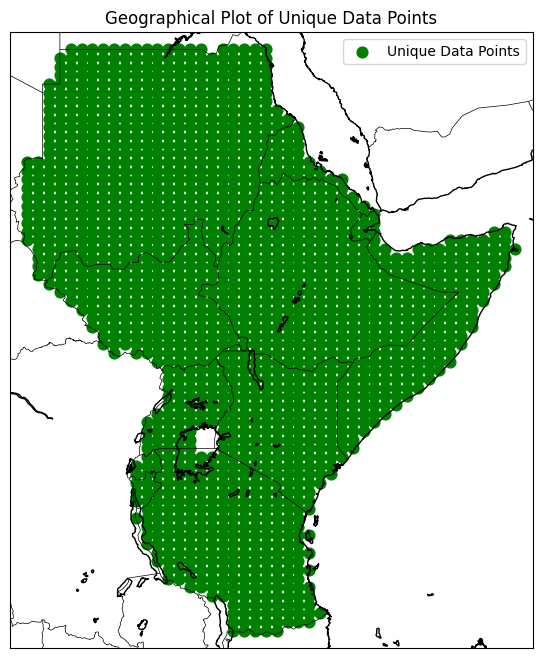

In [6]:
def plot_geographical_data(polars_df: pl.DataFrame):
    """
    Plots unique geographical data points on a map from a Polars DataFrame containing latitude and longitude.

    Parameters:
    - polars_df (pl.DataFrame): A Polars DataFrame with 'lat' and 'lon' columns.

    Author:
    - Adam Przychodni
    """
    # Ensure the DataFrame has the necessary columns
    if not {'lat', 'lon'}.issubset(polars_df.columns):
        raise ValueError("DataFrame must contain 'lat' and 'lon' columns")

    # Select the latitude and longitude columns and get unique pairs
    unique_coords = polars_df.select(['lat', 'lon']).unique()

    # Extract longitude and latitude columns from the unique coordinates
    lons = unique_coords.get_column('lon').to_numpy()
    lats = unique_coords.get_column('lat').to_numpy()

    # Set up the plot with a specified size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a Basemap instance with a cylindrical projection
    m = Basemap(projection='cyl', llcrnrlon=lons.min() - 1, llcrnrlat=lats.min() - 1,
                urcrnrlon=lons.max() + 1, urcrnrlat=lats.max() + 1, resolution='i', ax=ax)

    # Draw coastlines and countries for better map visualization
    m.drawcoastlines()
    m.drawcountries()

    # Convert latitude and longitude to map projection coordinates
    x, y = m(lons, lats)

    # Plot the data points with a green color, 'o' marker, and size of 60
    m.scatter(x, y, color='green', label='Unique Data Points', marker='o', s=60)

    # Add a legend and a title to the plot
    plt.legend()
    plt.title('Geographical Plot of Unique Data Points')

    # Display the plot
    plt.show()

    # Close the plot to free up memory
    plt.close(fig)
    
    # Explicitly delete variables and collect garbage
    del m, x, y, lons, lats, unique_coords, fig, ax
    gc.collect()

# Example usage:
plot_geographical_data(polars_df)


### Missing values

In [7]:
def calculate_missing_percentages(df: pl.DataFrame) -> pl.DataFrame:
    """
    Calculates the percentage of missing values in each column of a Polars DataFrame.

    Parameters:
    - df (pl.DataFrame): The input DataFrame with potentially missing values.

    Returns:
    - pl.DataFrame: A DataFrame with one row showing the percentage of missing values for each column.

    Example of usage:
    missing_percentages = calculate_missing_percentages(polars_df)
    print(missing_percentages)
    """
    total_rows = df.height  # Access the number of rows in the DataFrame
    missing_counts = df.select([pl.col(column).is_null().sum().alias(column) for column in df.columns])
    missing_percentage = missing_counts / total_rows * 100
    
    return missing_percentage

# Example usage
missing_percentages = calculate_missing_percentages(polars_df)


In [8]:
missing_percentages

time,lat,lon,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN,PRECTOTCORR_mm
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Descriptive statistics

### Summmary statistics

In [9]:
summary_stats_polars = polars_df.describe()
summary_stats_polars

statistic,time,lat,lon,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN,PRECTOTCORR_mm
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""13819645""",1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7,1.3819645e7
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2012-07-02 00:…",7.353799,35.12234,12.654755,25.495508,300.007256,92547.269564,2.868536,3.996069,0.010741,52.009169,0.461128,0.469582,0.362034,45.163763,250.906112,1.84093
"""std""",null,8.25859,6.040151,22.433482,4.840052,5.357295,5280.050827,1.436152,1.756201,0.004362,22.330385,0.174819,0.176594,0.244099,29.408095,44.793485,5.648646
"""min""","""2001-01-01 00:…",-11.5,23.125,0.0,4.514063,277.945312,72258.625,0.0,0.3046875,0.000488,2.25,0.0859375,0.0859375,0.015625,-30.289062,10.607422,0.0
"""25%""","""2006-10-02 00:…",1.5,30.625,0.0,22.31875,296.453125,89083.25,1.78125,2.65625,0.007385,34.0625,0.34375,0.3515625,0.140625,18.641602,225.429688,0.0
"""50%""","""2012-07-02 00:…",8.0,35.0,0.359375,25.732813,300.101562,94324.25,2.6796875,3.765625,0.011597,54.75,0.453125,0.4609375,0.3359375,42.663086,255.482422,0.044121
"""75%""","""2018-04-02 00:…",13.5,38.75,15.734375,28.740625,303.648438,96190.1875,3.7421875,5.0625,0.01416,70.1875,0.5859375,0.59375,0.5546875,70.384766,281.868164,1.389255
"""max""","""2024-01-01 00:…",22.0,51.25,184.070312,40.748438,319.820312,101918.0625,12.796875,16.78125,0.022827,97.75,1.0,1.0,1.0,114.833008,369.414062,1548.481804


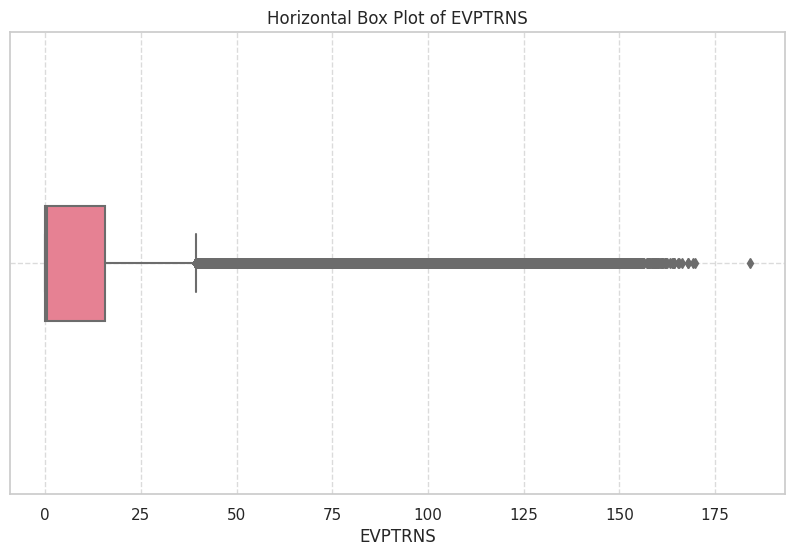

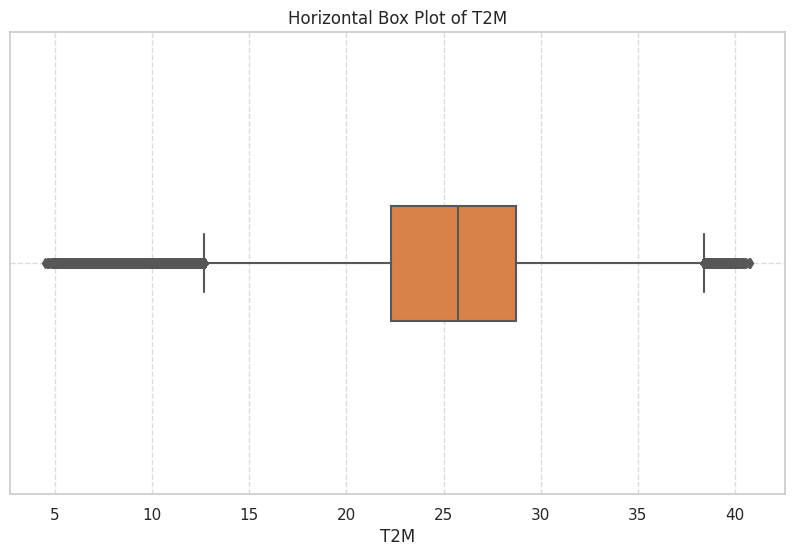

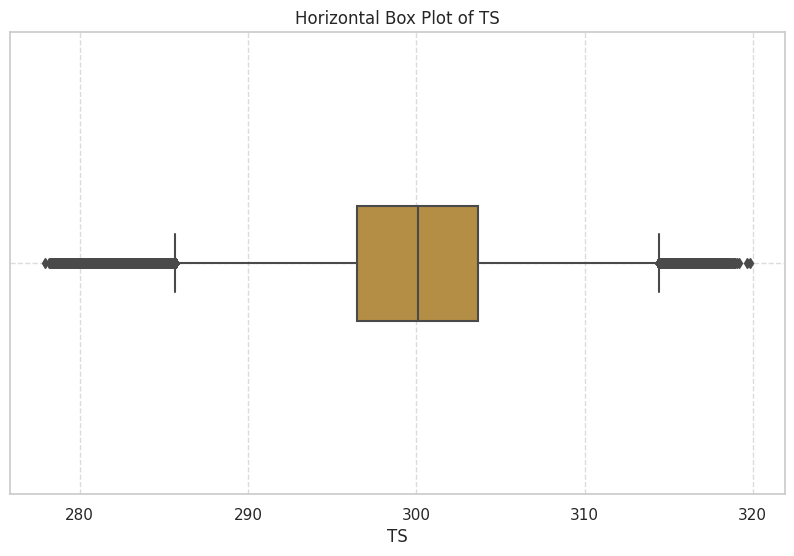

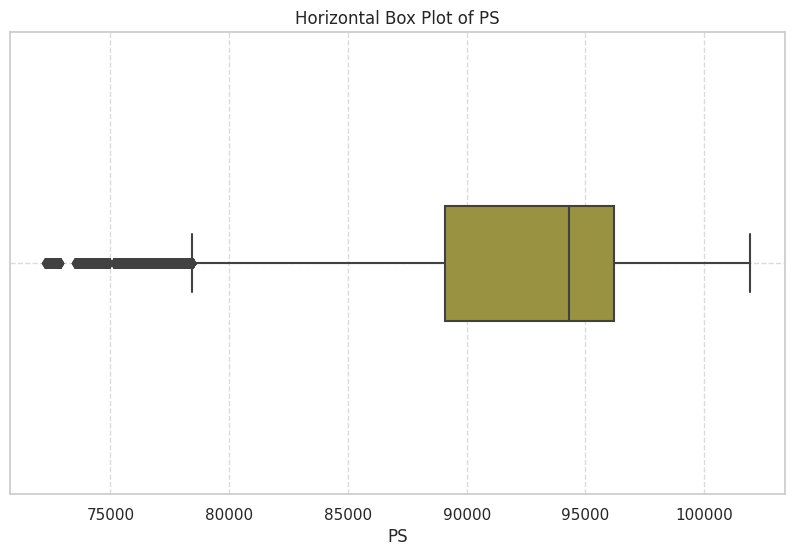

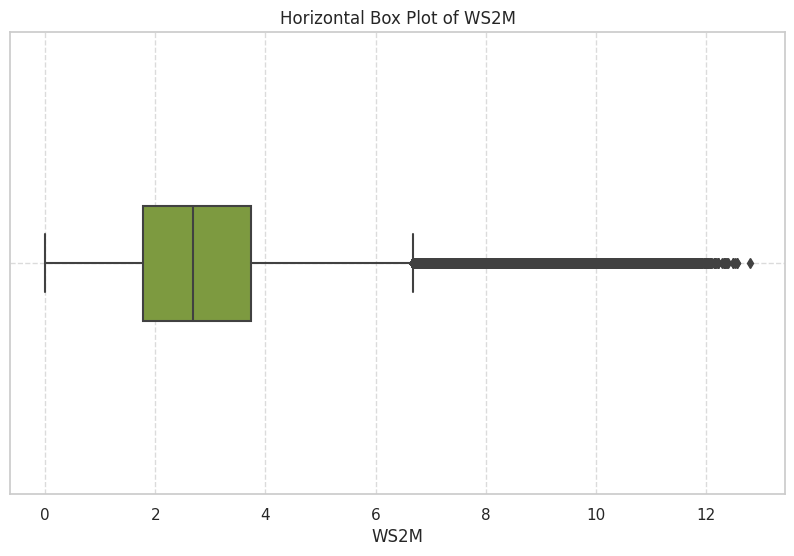

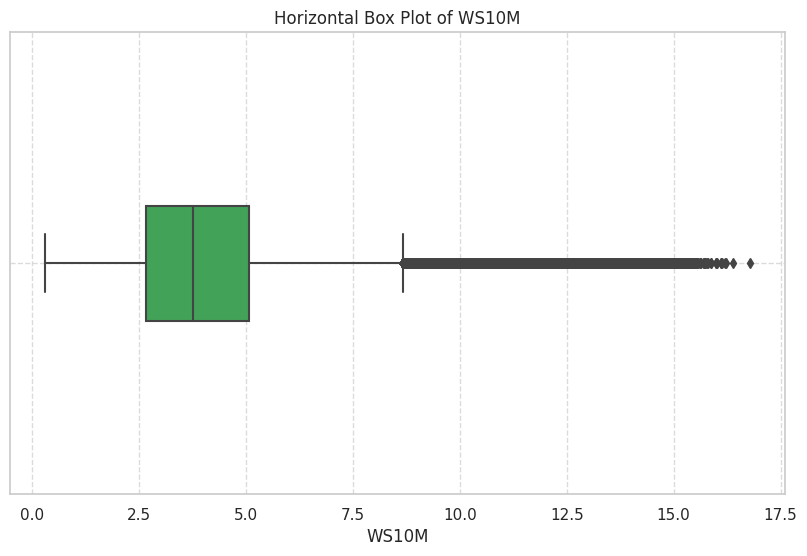

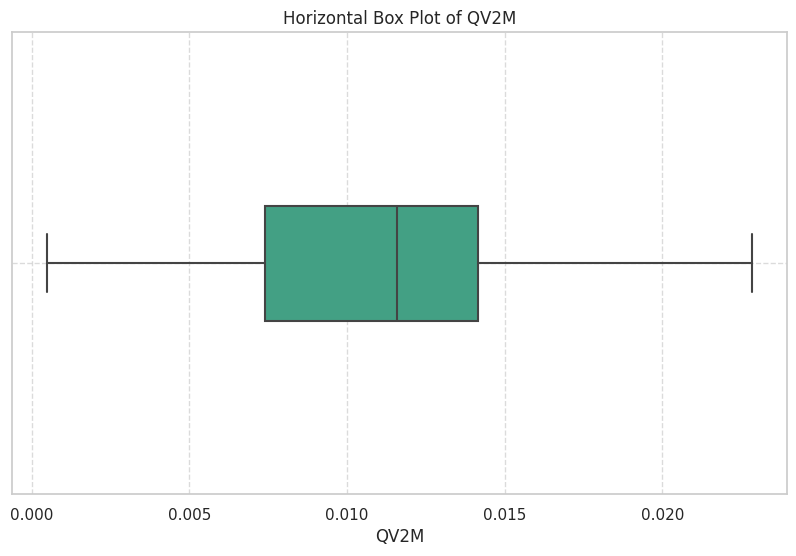

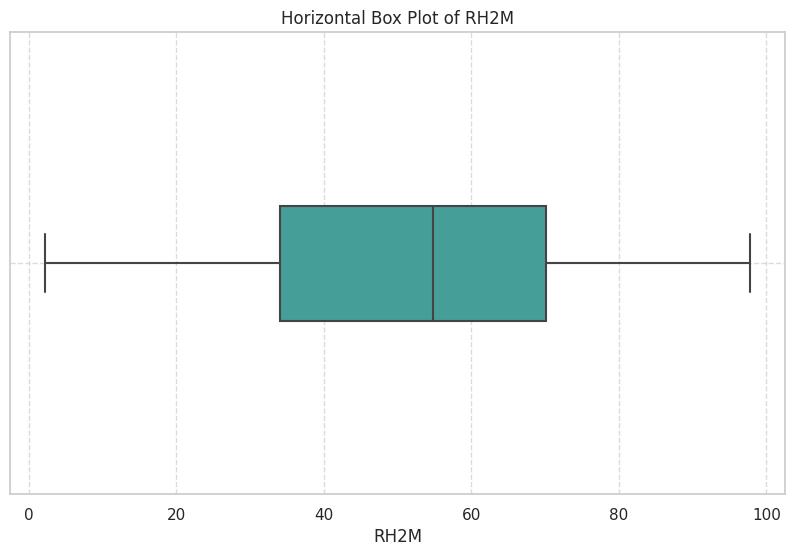

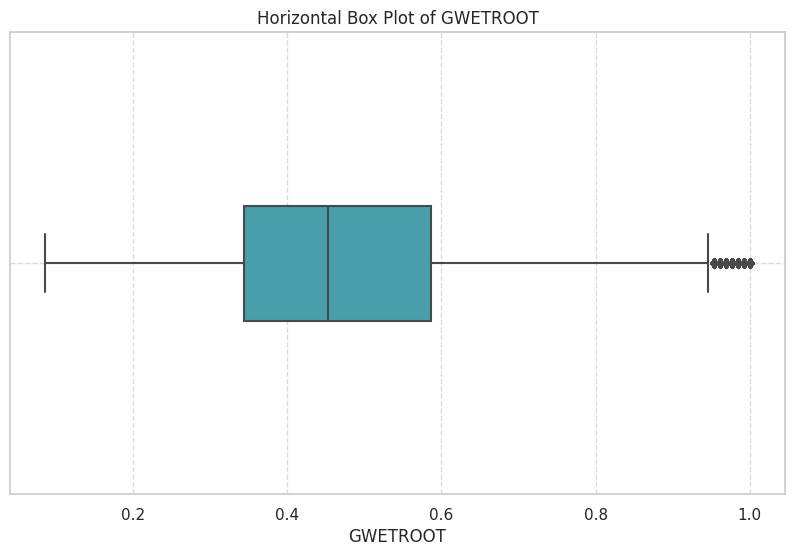

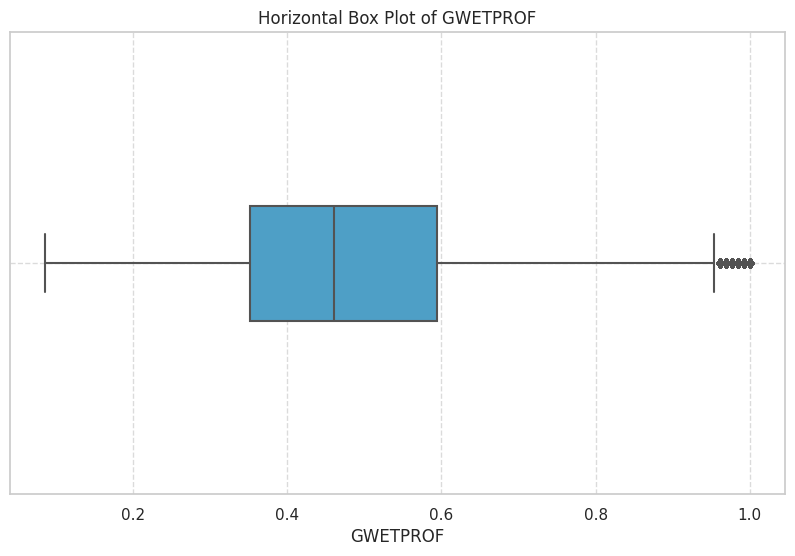

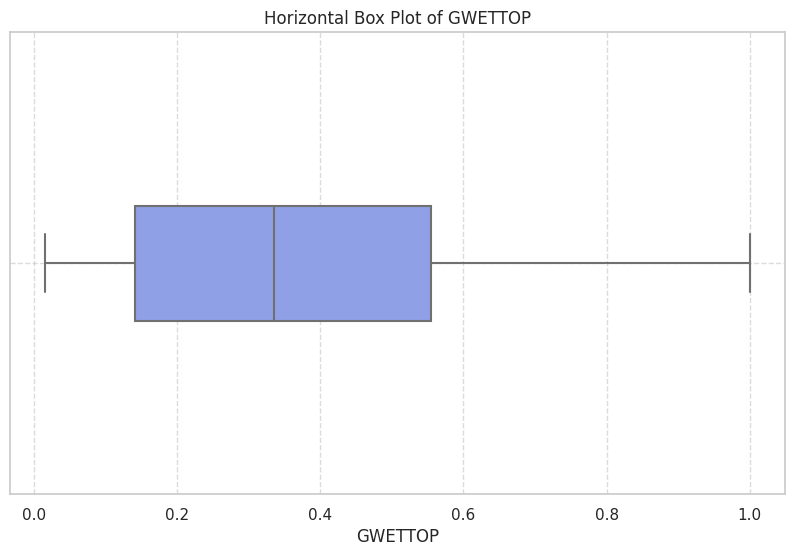

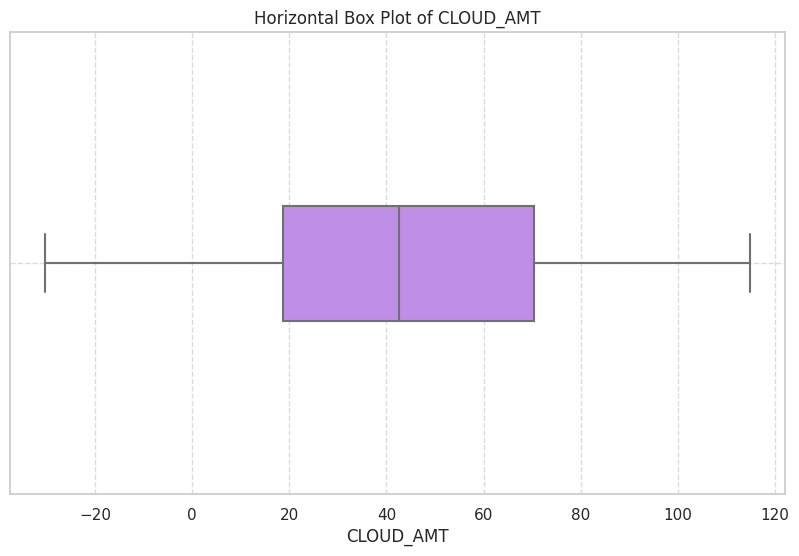

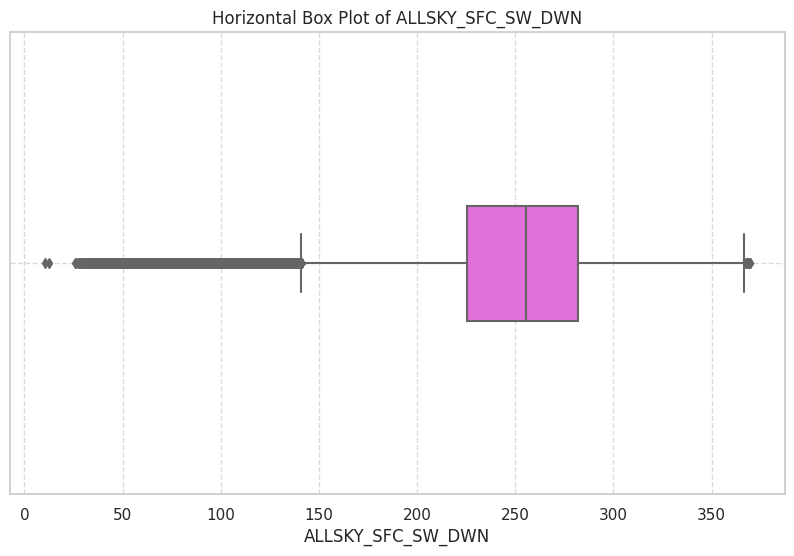

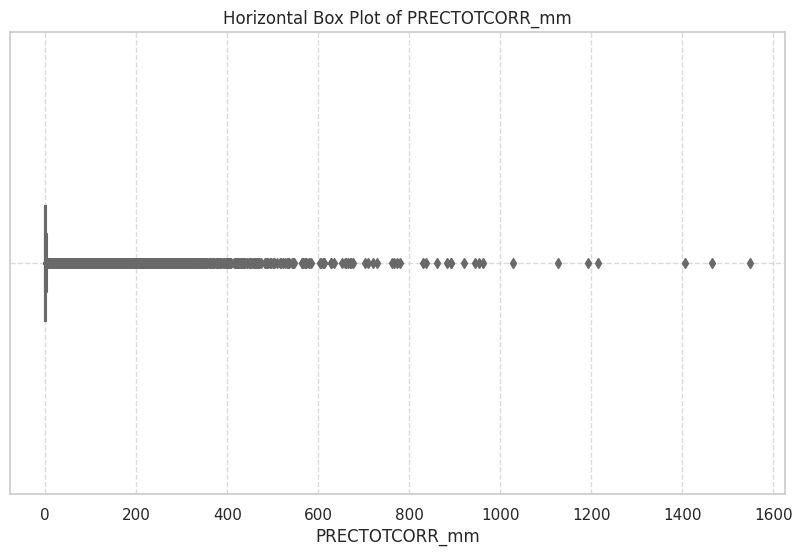

In [10]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(polars_df, box_width=0.5):
    """
    Plot horizontal box plots for each variable in the Polars DataFrame except 'time', 'lat', and 'lon',
    with an adjustable width for the boxes.

    Parameters:
    - polars_df (pl.DataFrame): The input Polars DataFrame containing the data to be plotted.
    - box_width (float): The width of the box in the box plot. Default is 0.5.

    Returns:
    None, displays the box plots.
    """
    # Set the aesthetic appearance of the plots
    sns.set(style="whitegrid")

    # Get the list of columns to plot, excluding 'time', 'lat', and 'lon'
    columns_to_plot = [col for col in polars_df.columns if col not in ['time', 'lat', 'lon']]

    # Define a color palette
    palette = sns.color_palette("husl", len(columns_to_plot))

    # Loop through each column and create a separate boxplot
    for idx, column in enumerate(columns_to_plot):
        # Selecting the column for visualization
        values = polars_df[column].to_numpy()  # Convert to NumPy array for Matplotlib

        # Creating the horizontal box plot for the current column
        plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
        sns.boxplot(x=values, color=palette[idx], width=box_width)  # Use seaborn for a colored boxplot with adjusted width
        plt.xlabel(f'{column}')  # X-axis Label
        plt.title(f'Horizontal Box Plot of {column}')  # Title of the plot
        plt.grid(True, linestyle='--', alpha=0.7)  # Enable grid for better readability
        plt.show()

# Example usage:
plot_boxplots(polars_df, box_width=0.25)


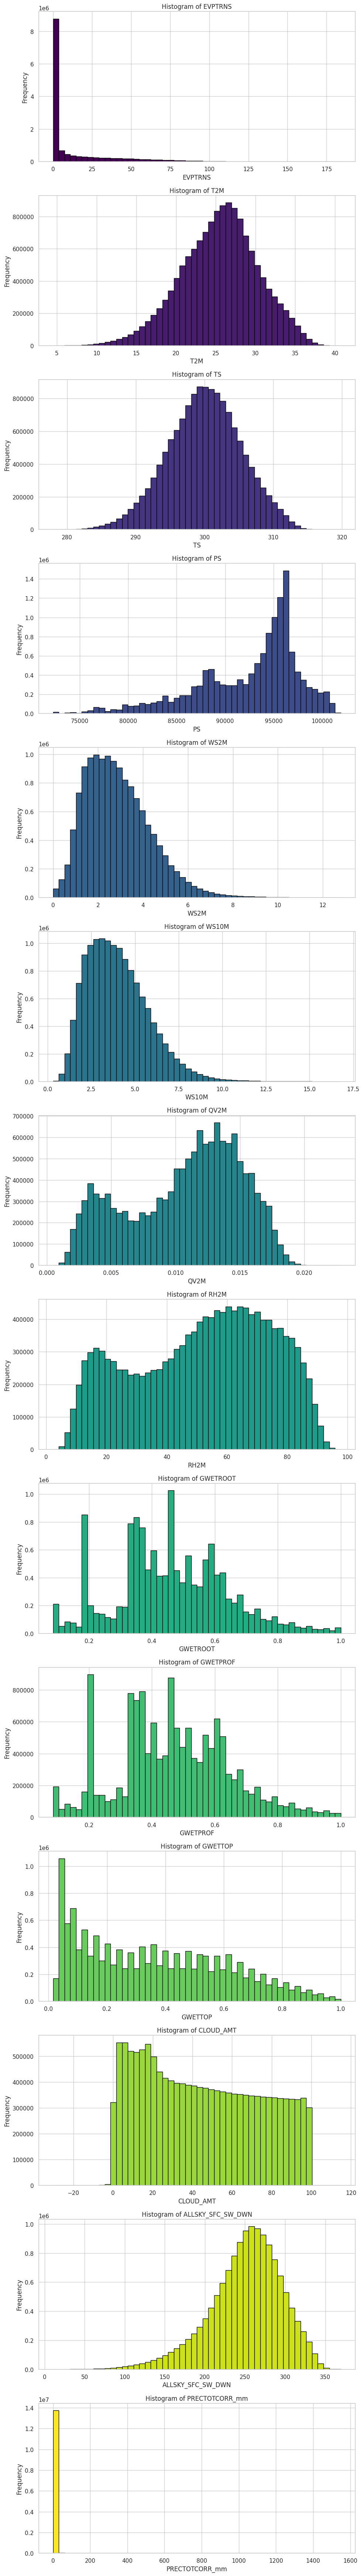

In [11]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_histograms(dataframe: pl.DataFrame, exclude_columns: list = ['time', 'lat', 'lon'], n_bins: int = 50):
    """
    Plot histograms for each column in the DataFrame except the specified columns.

    Parameters:
    - dataframe (pl.DataFrame): The Polars DataFrame containing the data.
    - exclude_columns (list): A list of column names to exclude from histogram plotting.
    - n_bins (int): Number of bins for each histogram.

    This function plots each selected column's histogram in a different color.
    """
    # Selecting the columns that are not in the exclude list
    hist_columns = [col for col in dataframe.columns if col not in exclude_columns]

    # Creating a figure with subplots; adjust the figure size and layout as necessary
    fig, axs = plt.subplots(len(hist_columns), 1, figsize=(10, 5 * len(hist_columns)), tight_layout=True)

    # If there's only one column to plot, axs may not be an array, handle single histogram case
    if len(hist_columns) == 1:
        axs = [axs]

    # Create a colormap
    colors = cm.viridis(np.linspace(0, 1, len(hist_columns)))

    # Plotting histogram for each selected column
    for ax, col, color in zip(axs, hist_columns, colors):
        # Extract the data for the column
        data = dataframe[col].to_numpy()  # Convert to numpy array for compatibility with matplotlib
        
        # Plot the histogram
        ax.hist(data, bins=n_bins, color=color, edgecolor='black')
        
        # Setting the title for each subplot
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    # Display the plots
    plt.show()

# Example of usage:
plot_histograms(polars_df)  # Assuming 'polars_df' is your Polars DataFrame


In [15]:
polars_df

time,lat,lon,PRECTOTCORR,EVPTRNS,T2M,TS,PS,WS2M,WS10M,QV2M,RH2M,GWETROOT,GWETPROF,GWETTOP,CLOUD_AMT,ALLSKY_SFC_SW_DWN,PRECTOTCORR_mm
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01 00:00:00,-4.5,39.375,0.000007,20.554688,300.632812,301.40625,100119.3125,4.09375,5.2890625,0.016479,72.6875,0.4453125,0.4765625,0.40625,43.009766,263.890625,0.63943
2001-01-01 00:00:00,-4.0,29.375,0.000033,73.023438,296.335938,296.882812,88100.625,1.109375,1.5,0.01416,70.4375,0.8359375,0.8359375,0.8515625,94.381348,190.95752,2.88367
2001-01-01 00:00:00,-4.0,30.0,0.000063,51.226562,293.84375,293.578125,85654.125,0.15625,0.8203125,0.013672,78.4375,0.7578125,0.765625,0.7890625,93.867188,197.355469,5.45587
2001-01-01 00:00:00,-4.0,38.75,0.000008,8.21875,298.867188,300.398438,95377.0,3.2109375,4.5234375,0.01416,68.8125,0.515625,0.546875,0.453125,44.986328,242.912109,0.715677
2001-01-01 00:00:00,-4.0,39.375,0.000003,4.1875,300.398438,301.90625,98870.0,3.3515625,4.703125,0.015198,69.0625,0.4609375,0.4921875,0.4140625,45.098633,244.987305,0.254067
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-01-01 00:00:00,17.0,37.5,0.000005,0.0625,298.726562,301.460938,95827.25,2.28125,3.03125,0.011597,58.375,0.3828125,0.3828125,0.2578125,4.707031,216.121094,0.419501
2024-01-01 00:00:00,17.0,38.125,0.00002,1.0,294.6875,297.023438,89910.5625,1.625,2.2109375,0.012085,71.75,0.3984375,0.40625,0.3828125,27.514648,175.00293,1.74302
2024-01-01 00:00:00,17.0,38.75,0.000041,1.25,296.453125,298.164062,95175.25,2.140625,2.7421875,0.014771,79.4375,0.4609375,0.4609375,0.453125,44.016602,150.183594,3.529251
